## Importing libraries

## Pytorch approach

In this kernel I work with data from Google QUEST Q&A Labeling competition.
In this challenge we work with... opinions. This could help Q&A systems, so let's try!
Code will, of course, be in Pytorch

#### Change log
* V25: Adding USE like in https://www.kaggle.com/ldm314/universal-sentence-encoder-keras-nn/
* V26: changing preprocessing
* V32: reverting to previous preprocessing approach. Use more models for predictions.
* v33: fixed model paths
* it doesn't work, so revert to previous version.
* V37: adding bert embeddings (not using bert itself for training) like in this kernel: https://www.kaggle.com/abhishek/distilbert-use-features-oof
* V40: limit the number of epochs for training (due to 2h limit). Use some preprocessed embeddings instead of creating them in kernel.

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from urllib.parse import urlparse
%matplotlib inline
import re
from category_encoders.ordinal import OrdinalEncoder
import spacy
import gc
import gensim
from nltk.tokenize import TweetTokenizer
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import time
pd.set_option('max_colwidth',400)
from scipy.stats import spearmanr
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import scipy as sp
import random
from sklearn.preprocessing import OneHotEncoder
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data


import torch.utils.data
from torch.optim import lr_scheduler
from scipy.stats import spearmanr
import numpy as np
import time
from tqdm import tqdm
import pickle
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
import tensorflow_hub as hub
import keras.backend as K
import sys
!pip install ../input/sacremoses/sacremoses-master/ > /dev/null
sys.path.insert(0, "../input/transformers/transformers-master/")
import transformers

Using TensorFlow backend.


## Helper functions and classes

### Text processing

In [2]:
# added preprocessing from https://www.kaggle.com/wowfattie/3rd-place/data

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\n', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

    return df

### Building an embedding matrix

In [3]:

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix_adv(embedding_path: str = '',
                 embedding_path_spellcheck: str = r'f:\embeddings\wiki-news-300d-1M\wiki-news-300d-1M.vec',
                 word_dict: dict = None, lemma_dict: dict = None, max_features: int = 100000,
                 embed_size: int= 300, ):
    spell_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path_spellcheck)
    words = spell_model.index2word
    w_rank = {}
    for i, word in enumerate(words):
        w_rank[word] = i
    WORDS = w_rank

    def P(word):
        "Probability of `word`."
        # use inverse of rank as proxy
        # returns 0 if the word isn't in the dictionary
        return - WORDS.get(word, 0)

    def correction(word):
        "Most probable spelling correction for word."
        return max(candidates(word), key=P)

    def candidates(word):
        "Generate possible spelling corrections for word."
        return (known([word]) or known(edits1(word)) or [word])

    def known(words):
        "The subset of `words` that appear in the dictionary of WORDS."
        return set(w for w in words if w in WORDS)

    def edits1(word):
        "All edits that are one edit away from `word`."
        letters = 'abcdefghijklmnopqrstuvwxyz'
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
        inserts = [L + c + R for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def edits2(word):
        "All edits that are two edits away from `word`."
        return (e2 for e1 in edits1(word) for e2 in edits1(e1))

    def singlify(word):
        return "".join([letter for i, letter in enumerate(word) if i == 0 or letter != word[i - 1]])


    # embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding='utf-8'))

    # embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
    embedding_index = load_embeddings(embedding_path)

    nb_words = min(max_features, len(word_dict))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    unknown_words = []
    for word, i in word_dict.items():
        key = word
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.capitalize())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        unknown_words.append(key)

    print(f'{len(unknown_words) * 100 / len(word_dict):.4f}% words are not in embeddings')
    return embedding_matrix, nb_words, unknown_words


def get_word_lemma_dict(full_text: list = None, ):
    nlp = spacy.load('en_core_web_lg', disable=['parser','ner','tagger'])
    nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
    word_dict = {}
    word_index = 1
    lemma_dict = {}
    docs = nlp.pipe(full_text, n_threads = os.cpu_count())
    for doc in docs:
        for token in doc:
            if (token.text not in word_dict) and (token.pos_ is not "PUNCT"):
                word_dict[token.text] = word_index
                word_index += 1
                lemma_dict[token.text] = token.lemma_

    return lemma_dict, word_dict


def build_matrix(embedding_path: str = '',
                 embedding_path_spellcheck: str = r'f:\embeddings\wiki-news-300d-1M\wiki-news-300d-1M.vec',
                 word_dict: dict = None, max_features: int = 100000,
                 embed_size: int= 300, ):

    # embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding='utf-8'))
    embedding_index = load_embeddings(embedding_path)

    nb_words = min(max_features, len(word_dict))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    unknown_words = []
    for word, i in word_dict.items():
        key = word
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.capitalize())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        unknown_words.append(key)

    print(f'{len(unknown_words) * 100 / len(word_dict):.4f}% words are not in embeddings')
    return embedding_matrix, nb_words, unknown_words


def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Creating additional features

In [4]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def fetch_vectors(string_list, batch_size=64, max_len = 512):
    # inspired by https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
    DEVICE = torch.device("cuda")
    tokenizer = transformers.DistilBertTokenizer.from_pretrained("../input/distilbertbaseuncased/")
    model = transformers.DistilBertModel.from_pretrained("../input/distilbertbaseuncased/")
    model.to(DEVICE)

    fin_features = []
    for data in chunks(string_list, batch_size):
        tokenized = []
        for x in data:
            x = " ".join(x.strip().split()[:500])
            tok = tokenizer.encode(x, add_special_tokens=True)
            tokenized.append(tok[:max_len])

        
        padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized])
        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded).to(DEVICE)
        attention_mask = torch.tensor(attention_mask).to(DEVICE)

        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        features = last_hidden_states[0][:, 0, :].cpu().numpy()
        fin_features.append(features)

    fin_features = np.vstack(fin_features)
    return fin_features

In [5]:
def get_embedding_features(train, test, input_columns, only_test = False, batch_size = 4):
    """
    https://www.kaggle.com/ragnar123/simple-lgbm-solution-baseline?scriptVersionId=24198335
    """
    
    # load universal sentence encoder model to get sentence ambeddings
    module_url = "../input/universalsentenceencoderlarge4/"
    embed = hub.load(module_url)
    
    # create empty dictionaries to store final results
    if not only_test:
        embedding_train = {}
    embedding_test = {}

    # iterate over text columns to get senteces embeddings with the previous loaded model
    for text in input_columns:
    
        print(text)
        if not only_test:
            train_text = train[text].str.replace('?', '.').str.replace('!', '.').tolist()
        test_text = test[text].str.replace('?', '.').str.replace('!', '.').tolist()
    
        # create empy list to save each batch
        curr_train_emb = []
        curr_test_emb = []
    
        # define a batch to transform senteces to their correspinding embedding (1 X 512 for each sentece)
        if not only_test:
            ind = 0
            while ind * batch_size < len(train_text):
                curr_train_emb.append(embed(train_text[ind * batch_size: (ind + 1) * batch_size])['outputs'].numpy())
                ind += 1
        
        ind = 0
        while ind * batch_size < len(test_text):
            curr_test_emb.append(embed(test_text[ind * batch_size: (ind + 1) * batch_size])['outputs'].numpy())
            ind += 1

        # stack arrays to get a 2D array (dataframe) corresponding with all the sentences and dim 512 for columns (sentence encoder output)
        if not only_test:
            embedding_train[text + '_embedding'] = np.vstack(curr_train_emb)
        embedding_test[text + '_embedding'] = np.vstack(curr_test_emb)
    
    del embed
    K.clear_session()
    gc.collect()
    
    if only_test:
        return embedding_test
    else:
        return embedding_train, embedding_test

def get_dist_features(embedding_train, embedding_test):
    
    # define a square dist lambda function were (x1 - y1) ^ 2 + (x2 - y2) ^ 2 + (x3 - y3) ^ 2 + ... + (xn - yn) ^ 2
    # with this we get one vector of dimension 6079
    l2_dist = lambda x, y: np.power(x - y, 2).sum(axis = 1)
    
    # define a cosine dist lambda function were (x1 * y1) ^ 2 + (x2 * y2) + (x3 * y3) + ... + (xn * yn)
    cos_dist = lambda x, y: (x * y).sum(axis = 1)
    
    # transpose it because we have 6 vector of dimension 6079, need 6079 x 6
    dist_features_train = np.array([
        l2_dist(embedding_train['question_title_embedding'], embedding_train['answer_embedding']),
        l2_dist(embedding_train['question_body_embedding'], embedding_train['answer_embedding']),
        l2_dist(embedding_train['question_body_embedding'], embedding_train['question_title_embedding']),
        cos_dist(embedding_train['question_title_embedding'], embedding_train['answer_embedding']),
        cos_dist(embedding_train['question_body_embedding'], embedding_train['answer_embedding']),
        cos_dist(embedding_train['question_body_embedding'], embedding_train['question_title_embedding'])]).T
    
    # transpose it because we have 6 vector of dimension 6079, need 6079 x 6
    dist_features_test = np.array([
        l2_dist(embedding_test['question_title_embedding'], embedding_test['answer_embedding']),
        l2_dist(embedding_test['question_body_embedding'], embedding_test['answer_embedding']),
        l2_dist(embedding_test['question_body_embedding'], embedding_test['question_title_embedding']),
        cos_dist(embedding_test['question_title_embedding'], embedding_test['answer_embedding']),
        cos_dist(embedding_test['question_body_embedding'], embedding_test['answer_embedding']),
        cos_dist(embedding_test['question_body_embedding'], embedding_test['question_title_embedding'])]).T
    
    return dist_features_train, dist_features_test

### Training and predicting functions

In [6]:
# training the model

def train_model(model, train_loader, valid_loader, n_epochs=5, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    patience = 2

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
    best_score = 0

    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.

        for question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature, y_batch in tqdm(train_loader, disable=True):
            question = question.long().cuda()
            answer = answer.long().cuda()
            title = title.long().cuda()
            category = category.long().cuda()
            host = host.long().cuda()
            use_emb_q = use_emb_q.cuda()
            use_emb_a = use_emb_a.cuda()
            use_emb_t = use_emb_t.cuda()
            dist_feature = dist_feature.cuda()
            
            y_batch = y_batch.cuda()
            y_pred = model(question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature)

            loss = loss_fn(y_pred.double(), y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        model.eval()

        avg_val_loss = 0.
        preds = []
        original = []
        for i, (question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature, y_batch) in enumerate(valid_loader):
            question = question.long().cuda()
            answer = answer.long().cuda()
            title = title.long().cuda()
            category = category.long().cuda()
            host = host.long().cuda()
            use_emb_q = use_emb_q.cuda()
            use_emb_a = use_emb_a.cuda()
            use_emb_t = use_emb_t.cuda()
            dist_feature = dist_feature.cuda()
            
            y_batch = y_batch.cuda()
            y_pred = model(question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature).detach()

            avg_val_loss += loss_fn(y_pred.double(), y_batch).item() / len(valid_loader)
            preds.append(y_pred.cpu().numpy())
            original.append(y_batch.cpu().numpy())
            
        score = 0
        for i in range(30):
            score += np.nan_to_num(
                spearmanr(np.concatenate(original)[:, i], np.concatenate(preds)[:, i]).correlation / 30)
        elapsed_time = time.time() - start_time
        
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t spearman={:.2f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, avg_loss, avg_val_loss, score, elapsed_time))

        scheduler.step(avg_val_loss)

        valid_score = score
        if valid_score > best_score:
            best_score = valid_score
            p = 0
            torch.save(model.state_dict(), 'model.pt')

        # check if validation loss didn't improve
        if valid_score <= best_score:
            p += 1
            print(f'{p} epochs of non improving score')
            if p > patience:
                print('Stopping training')
                stop = True
                break
                
        model.load_state_dict(torch.load('model.pt'))
                
    return model


def make_prediction(test_loader: DataLoader = None, model = None):
    prediction = np.zeros((len(test_loader.dataset), 30))
    model.eval()
    for i, (question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature, _) in enumerate(test_loader):

        start_index = i * test_loader.batch_size
        end_index   = min(start_index + test_loader.batch_size, len(test_loader.dataset))
        question = question.long().cuda()
        answer = answer.long().cuda()
        title = title.long().cuda()
        category = category.long().cuda()
        host = host.long().cuda()
        use_emb_q = use_emb_q.cuda()
        use_emb_a = use_emb_a.cuda()
        use_emb_t = use_emb_t.cuda()
        dist_feature = dist_feature.cuda()
        y_pred = model(question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature).detach()
        y_pred = torch.sigmoid(y_pred)
        prediction[start_index:end_index, :] +=  y_pred.detach().cpu().numpy()
        
    return prediction

### Model

In [7]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)

        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0

        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)

        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))

    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim),
            self.weight
        ).view(-1, step_dim)

        if self.bias:
            eij = eij + self.b

        eij = torch.tanh(eij)
        a = torch.exp(eij)

        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

    
class GELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)


class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
    
class Mish(nn.Module):
    """
    Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
    https://arxiv.org/abs/1908.08681v1
    implemented for PyTorch / FastAI by lessw2020 
    github: https://github.com/lessw2020/mish
    
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))
    
    
    
class NeuralNet5(nn.Module):
    def __init__(self,
                 hidden_size: int = 128,
                 max_len: int = 500,
                 max_len_title: int = 30,
                 n_cat: int = 3,
                 cat_emb: int = 6,
                 n_host: int = 55,
                 host_emb: int = 28,
                 additional_embedding_shape: int = 512,
                 embedding_matrix=None):
        super(NeuralNet5, self).__init__()

        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.embedding_dropout = SpatialDropout(0.3)
        
        self.category_embedding = nn.Embedding(n_cat, int(cat_emb))
        self.host_embedding = nn.Embedding(n_host, int(host_emb))

        self.linear_q_add = nn.Linear(300, 128)
        self.linear_q_add1 = nn.Linear(128, 30)
        self.bilinear_add = nn.Bilinear(30, 30, 30)

        self.lstm_q = nn.LSTM(300, hidden_size, bidirectional=True, batch_first=True)
        self.gru_q = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm_a = nn.LSTM(300, hidden_size, bidirectional=True, batch_first=True)
        self.gru_a = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm_t = nn.LSTM(300, hidden_size, bidirectional=True, batch_first=True)
        self.gru_t = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm_attention_q = Attention(hidden_size * 2, max_len)
        self.gru_attention_q = Attention(hidden_size * 2, max_len)

        self.lstm_attention_a = Attention(hidden_size * 2, max_len)
        self.gru_attention_a = Attention(hidden_size * 2, max_len)

        self.lstm_attention_t = Attention(hidden_size * 2, max_len_title)
        self.gru_attention_t = Attention(hidden_size * 2, max_len_title)

        self.linear_q = nn.Linear(1024, 64)
        self.relu_q = Mish()

        self.linear_a = nn.Linear(1024, 64)
        self.relu_a = Mish()

        self.linear_t = nn.Linear(1024, 64)
        self.relu_t = Mish()
        
        self.linear_q_emb = nn.Linear(additional_embedding_shape, 64)
        self.relu_q_emb = Mish()

        self.linear_a_emb = nn.Linear(additional_embedding_shape, 64)
        self.relu_a_emb = Mish()

        self.linear_t_emb = nn.Linear(additional_embedding_shape, 64)
        self.relu_t_emb = Mish()

        self.linear1 = nn.Sequential(nn.Linear(256 + int(cat_emb) + int(host_emb) + 6, 64),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(0.5))

        self.linear_q_out = nn.Linear(64, 21)

        self.bilinear = nn.Bilinear(64, 64, 64)
        self.bilinear_emb = nn.Bilinear(64, 64, 64)
        self.linear2 = nn.Sequential(nn.Linear(390, 64),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(0.5))

        self.linear_aq_out = nn.Linear(64, 9)

    def forward(self, question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature):
        h_embedding_q = self.embedding(question)
        h_embedding_q = self.embedding_dropout(h_embedding_q)

        h_lstm_q, _ = self.lstm_q(h_embedding_q)
        h_gru_q, _ = self.gru_q(h_lstm_q)

        h_lstm_atten_q = self.lstm_attention_q(h_lstm_q)
        h_gru_atten_q = self.gru_attention_q(h_gru_q)

        avg_pool_q = torch.mean(h_gru_q, 1)
        max_pool_q, _ = torch.max(h_gru_q, 1)

        h_embedding_a = self.embedding(answer)
        h_embedding_a = self.embedding_dropout(h_embedding_a)

        h_lstm_a, _ = self.lstm_a(h_embedding_a)
        h_gru_a, _ = self.gru_a(h_lstm_a)

        h_lstm_atten_a = self.lstm_attention_a(h_lstm_a)
        h_gru_atten_a = self.gru_attention_a(h_gru_a)

        avg_pool_a = torch.mean(h_gru_a, 1)
        max_pool_a, _ = torch.max(h_gru_a, 1)

        h_embedding_t = self.embedding(title)
        h_embedding_t = self.embedding_dropout(h_embedding_t)

        h_lstm_t, _ = self.lstm_t(h_embedding_t)
        h_gru_t, _ = self.gru_t(h_lstm_t)

        h_lstm_atten_t = self.lstm_attention_t(h_lstm_t)
        h_gru_atten_t = self.gru_attention_t(h_gru_t)

        avg_pool_t = torch.mean(h_gru_t, 1)
        max_pool_t, _ = torch.max(h_gru_t, 1)

        category = self.category_embedding(category)
        host = self.host_embedding(host)
        
        add = torch.cat((h_embedding_q, h_embedding_a, h_embedding_t), 1)
        add = self.linear_q_add(torch.mean(add, 1))
        add = self.linear_q_add1(add)

        q = torch.cat((h_lstm_atten_q, h_gru_atten_q, avg_pool_q, max_pool_q), 1)
        a = torch.cat((h_lstm_atten_a, h_gru_atten_a, avg_pool_a, max_pool_a), 1)
        t = torch.cat((h_lstm_atten_t, h_gru_atten_t, avg_pool_t, max_pool_t), 1)
        
        q = self.relu_q(self.linear_q(q))
        a = self.relu_a(self.linear_a(a))
        t = self.relu_t(self.linear_t(t))

        q_emb = self.relu_q_emb(self.linear_q_emb(use_emb_q))
        a_emb = self.relu_a_emb(self.linear_a_emb(use_emb_a))
        t_emb = self.relu_t_emb(self.linear_t_emb(use_emb_t))
        
        hidden_q = self.linear1(torch.cat((q, t, q_emb, t_emb, category, host, dist_feature), 1))
        q_result = self.linear_q_out(hidden_q)

        bil_sim = self.bilinear(q, a)
        bil_sim_emb = self.bilinear_emb(q_emb, a_emb)
        
        hidden_aq = self.linear2(torch.cat((q, a, q_emb, a_emb, bil_sim, bil_sim_emb, dist_feature), 1))
        aq_result = self.linear_aq_out(hidden_aq)

        out = torch.cat([q_result, aq_result], 1)
        out = self.bilinear_add(out, add)

        return out

### Dataset class

In [8]:
class TextDataset(Dataset):

    def __init__(self, question_data, answer_data, title_data, category_data, host_data, use_embeddings, dist_features, idxs, targets=None):
        self.question_data = question_data[idxs]
        self.answer_data = answer_data[idxs]
        self.title_data = title_data[idxs]
        self.category_data = category_data[idxs]
        self.host_data = host_data[idxs]
        self.use_embeddings_q = use_embeddings['question_body_embedding'][idxs]
        self.use_embeddings_a = use_embeddings['answer_embedding'][idxs]
        self.use_embeddings_t = use_embeddings['question_title_embedding'][idxs]
        self.dist_features = dist_features[idxs]
        self.targets = targets[idxs] if targets is not None else np.zeros((self.question_data.shape[0], 30))

    def __getitem__(self, idx):
        question = self.question_data[idx]
        answer = self.answer_data[idx]
        title = self.title_data[idx]
        category = self.category_data[idx]
        host = self.host_data[idx]
        use_emb_q = self.use_embeddings_q[idx]
        use_emb_a = self.use_embeddings_a[idx]
        use_emb_t = self.use_embeddings_t[idx]
        dist_feature = self.dist_features[idx]
        target = self.targets[idx]

        return question, answer, title, category, host, use_emb_q, use_emb_a, use_emb_t, dist_feature, target

    def __len__(self):
        return len(self.question_data)

## Loading and preparing data

In [9]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = '/kaggle/input/google-quest-challenge'
sample_submission = pd.read_csv(f'{path}/sample_submission.csv')
test = pd.read_csv(f'{path}/test.csv').fillna(' ')
train = pd.read_csv(f'{path}/train.csv').fillna(' ')

In [10]:
train = clean_data(train, ['answer', 'question_body', 'question_title'])
test = clean_data(test, ['answer', 'question_body', 'question_title'])

In [11]:
seed_everything()

In [12]:
%%time
embedding_test = get_embedding_features(train, test, ['answer', 'question_body', 'question_title'], only_test=True)
embedding_train = {}
embedding_train['answer_embedding'] = np.load('/kaggle/input/qa-labeling-files-for-inference/embedding_train_answer_embedding.npy', allow_pickle=True)
embedding_train['question_body_embedding'] = np.load('/kaggle/input/qa-labeling-files-for-inference/embedding_train_question_body_embedding.npy', allow_pickle=True)
embedding_train['question_title_embedding'] = np.load('/kaggle/input/qa-labeling-files-for-inference/embedding_train_question_title_embedding.npy', allow_pickle=True)

answer
question_body
question_title
CPU times: user 47.6 s, sys: 4.59 s, total: 52.2 s
Wall time: 52.6 s


In [13]:
%%time
dist_features_train, dist_features_test  = get_dist_features(embedding_train, embedding_test)


CPU times: user 136 ms, sys: 4 ms, total: 140 ms
Wall time: 148 ms


In [14]:
tokenizer = Tokenizer()
full_text = list(train['question_body']) + \
                       list(train['answer']) + \
                       list(train['question_title']) + \
                       list(test['question_body']) + \
                       list(test['answer']) + \
                       list(test['question_title'])
tokenizer.fit_on_texts(full_text)

In [15]:
embed_size=300
embedding_path = "/kaggle/input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl"

In [16]:
%%time
lemma_dict, word_dict = get_word_lemma_dict(full_text)

CPU times: user 45.9 s, sys: 1.23 s, total: 47.1 s
Wall time: 50.1 s


In [17]:
%%time
embedding_matrix, nb_words, unknown_words = build_matrix(embedding_path, '/kaggle/input/wikinews300d1mvec/wiki-news-300d-1M.vec', tokenizer.word_index,
                                              100000, embed_size)
# embedding_matrix, nb_words, unknown_words = build_matrix_adv(embedding_path, '/kaggle/input/wikinews300d1mvec/wiki-news-300d-1M.vec', word_dict, lemma_dict,
#                                               100000, embed_size)

25.7148% words are not in embeddings
CPU times: user 7.62 s, sys: 2.62 s, total: 10.2 s
Wall time: 10.3 s


In [18]:
# tk.word_index = {k: v for k, v in tk.word_index.items() if k in word_dict.keys()}
# train['host'] = train['host'].apply(lambda x: x.split('.')[-2])
# test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
unique_hosts = list(set(train['host'].unique().tolist() + test['host'].unique().tolist()))
host_dict = {i + 1: e for i, e in enumerate(unique_hosts)}
host_dict_reverse = {v: k for k, v in host_dict.items()}

unique_categories = list(set(train['category'].unique().tolist() + test['category'].unique().tolist()))
category_dict = {i + 1: e for i, e in enumerate(unique_categories)}
category_dict_reverse = {v: k for k, v in category_dict.items()}
max_len = 500
max_len_title = 30
train_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_body']), maxlen = max_len)
train_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['answer']), maxlen = max_len)
train_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_title']), maxlen = max_len_title)

test_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_body']), maxlen = max_len)
test_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['answer']), maxlen = max_len)
test_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_title']), maxlen = max_len_title)

train_host = train['host'].apply(lambda x: host_dict_reverse[x]).values
train_category = train['category'].apply(lambda x: category_dict_reverse[x]).values

test_host = test['host'].apply(lambda x: host_dict_reverse[x]).values
test_category = test['category'].apply(lambda x: category_dict_reverse[x]).values

In [19]:
y = train[sample_submission.columns[1:]].values

In [20]:
num_workers = 0
bs = 16
n_cat = len(category_dict) + 1
cat_emb = min(np.ceil((len(category_dict)) / 2), 50)
n_host = len(host_dict)+1
host_emb = min(np.ceil((len(host_dict)) / 2), 50)

In [21]:
bs_test = 16
test_loader = DataLoader(TextDataset(test_question_tokenized, test_answer_tokenized, test_title_tokenized,
                                     test_category, test_host, embedding_test, dist_features_test, test.index),
                          batch_size=bs_test, shuffle=False, num_workers=num_workers)

## Training model

In [22]:
folds = KFold(n_splits=5, random_state=42)
preds = np.zeros((len(test), 30))
for fold_n, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    train_loader = DataLoader(TextDataset(train_question_tokenized, train_answer_tokenized, train_title_tokenized, train_category, train_host, embedding_train,
                                          dist_features_train, train_index, y),
                              batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(TextDataset(train_question_tokenized, train_answer_tokenized, train_title_tokenized, train_category, train_host, embedding_train,
                                          dist_features_train, valid_index, y),
                              batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
        
    model = NeuralNet5(embedding_matrix=embedding_matrix,
                       n_cat=n_cat,
                       cat_emb=cat_emb,
                       n_host=n_host,
                       host_emb=host_emb)
    model.cuda()

    model = train_model(model, train_loader, valid_loader, n_epochs=10, lr=0.001)
    prediction = make_prediction(test_loader, model)
    preds += prediction / folds.n_splits / 2
    
    gc.collect()
    torch.cuda.empty_cache()
    print()

Fold 1 started at Sun Dec  1 09:20:12 2019
Epoch 1/10 	 loss=0.4202 	 val_loss=0.3905 	 spearman=0.30 	 time=53.29s
1 epochs of non improving score
Epoch 2/10 	 loss=0.3889 	 val_loss=0.3827 	 spearman=0.33 	 time=52.67s
1 epochs of non improving score
Epoch 3/10 	 loss=0.3802 	 val_loss=0.3789 	 spearman=0.34 	 time=52.89s
1 epochs of non improving score
Epoch 4/10 	 loss=0.3760 	 val_loss=0.3791 	 spearman=0.35 	 time=52.93s
1 epochs of non improving score
Epoch 5/10 	 loss=0.3718 	 val_loss=0.3774 	 spearman=0.35 	 time=52.68s
1 epochs of non improving score
Epoch 6/10 	 loss=0.3682 	 val_loss=0.3779 	 spearman=0.35 	 time=52.75s
2 epochs of non improving score
Epoch 7/10 	 loss=0.3683 	 val_loss=0.3776 	 spearman=0.35 	 time=53.16s
1 epochs of non improving score
Epoch 8/10 	 loss=0.3608 	 val_loss=0.3766 	 spearman=0.36 	 time=52.76s
1 epochs of non improving score
Epoch 9/10 	 loss=0.3582 	 val_loss=0.3775 	 spearman=0.36 	 time=52.79s
1 epochs of non improving score
Epoch 10/10 

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Epoch 1/10 	 loss=0.4228 	 val_loss=0.3893 	 spearman=0.30 	 time=53.30s
1 epochs of non improving score
Epoch 2/10 	 loss=0.3894 	 val_loss=0.3816 	 spearman=0.33 	 time=53.30s
1 epochs of non improving score
Epoch 3/10 	 loss=0.3820 	 val_loss=0.3806 	 spearman=0.34 	 time=52.97s
1 epochs of non improving score
Epoch 4/10 	 loss=0.3761 	 val_loss=0.3774 	 spearman=0.35 	 time=52.96s
1 epochs of non improving score
Epoch 5/10 	 loss=0.3718 	 val_loss=0.3752 	 spearman=0.36 	 time=52.95s
1 epochs of non improving score
Epoch 6/10 	 loss=0.3687 	 val_loss=0.3745 	 spearman=0.36 	 time=53.57s
1 epochs of non improving score
Epoch 7/10 	 loss=0.3657 	 val_loss=0.3789 	 spearman=0.35 	 time=52.91s
2 epochs of non improving score
Epoch 8/10 	 loss=0.3654 	 val_loss=0.3755 	 spearman=0.36 	 time=52.97s
3 epochs of non improving score
Stopping training



### Training second model

The second model will use embeddings from bert.

In [23]:
del embedding_train
del embedding_test
del model
gc.collect()
torch.cuda.empty_cache()

In [24]:
%%time
# bert_embeddings_train = {}
bert_embeddings_test = {}
for col in ['answer', 'question_body', 'question_title']:
    # bert_embeddings_train[f'{col}_embedding'] = fetch_vectors(train[col].values, batch_size=4)
    bert_embeddings_test[f'{col}_embedding'] = fetch_vectors(train[col].values, batch_size=4)

CPU times: user 2min 5s, sys: 2min, total: 4min 5s
Wall time: 4min 5s


In [25]:
%%time
bert_embeddings_train = {}
for col in ['answer', 'question_body', 'question_title']:
    bert_embeddings_train[f'{col}_embedding'] = np.load(f'/kaggle/input/qa-labeling-files-for-inference/distill_train_{col}.npy')

CPU times: user 8 ms, sys: 20 ms, total: 28 ms
Wall time: 127 ms


In [26]:
bs_test = 16
test_loader = DataLoader(TextDataset(test_question_tokenized, test_answer_tokenized, test_title_tokenized,
                                     test_category, test_host, bert_embeddings_test, dist_features_test, test.index),
                          batch_size=bs_test, shuffle=False, num_workers=num_workers)

In [27]:
folds = KFold(n_splits=5, random_state=42)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    train_loader = DataLoader(TextDataset(train_question_tokenized, train_answer_tokenized, train_title_tokenized, train_category, train_host, bert_embeddings_train,
                                          dist_features_train, train_index, y),
                              batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(TextDataset(train_question_tokenized, train_answer_tokenized, train_title_tokenized, train_category, train_host, bert_embeddings_train,
                                          dist_features_train, valid_index, y),
                              batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
        
    model = NeuralNet5(embedding_matrix=embedding_matrix,
                       n_cat=n_cat,
                       cat_emb=cat_emb,
                       n_host=n_host,
                       host_emb=host_emb,
                       additional_embedding_shape=768)
    model.cuda()

    model = train_model(model, train_loader, valid_loader, n_epochs=10, lr=0.001)
    prediction = make_prediction(test_loader, model)
    preds += prediction / folds.n_splits / 2
    
    gc.collect()
    torch.cuda.empty_cache()
    print()

Fold 1 started at Sun Dec  1 10:07:18 2019
Epoch 1/10 	 loss=0.4188 	 val_loss=0.3979 	 spearman=0.28 	 time=53.63s
1 epochs of non improving score
Epoch 2/10 	 loss=0.3939 	 val_loss=0.3888 	 spearman=0.32 	 time=54.00s
1 epochs of non improving score
Epoch 3/10 	 loss=0.3871 	 val_loss=0.3864 	 spearman=0.33 	 time=53.84s
1 epochs of non improving score
Epoch 4/10 	 loss=0.3807 	 val_loss=0.3802 	 spearman=0.35 	 time=53.09s
1 epochs of non improving score
Epoch 5/10 	 loss=0.3770 	 val_loss=0.3828 	 spearman=0.35 	 time=53.49s
2 epochs of non improving score
Epoch 6/10 	 loss=0.3767 	 val_loss=0.3797 	 spearman=0.35 	 time=52.92s
3 epochs of non improving score
Stopping training

Fold 2 started at Sun Dec  1 10:12:43 2019
Epoch 1/10 	 loss=0.4207 	 val_loss=0.3916 	 spearman=0.29 	 time=52.91s
1 epochs of non improving score
Epoch 2/10 	 loss=0.3940 	 val_loss=0.3847 	 spearman=0.33 	 time=52.98s
1 epochs of non improving score
Epoch 3/10 	 loss=0.3874 	 val_loss=0.3788 	 spearman=0

In [28]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('submission.csv', index=False)

In [29]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.904740,0.632899,0.111767,0.641653,0.679514,0.689303,0.635093,0.591590,0.326604,0.004896,0.559111,0.380675,0.026395,0.021165,0.013871,0.029091,0.252017,0.134789,0.654684,0.000757,0.842758,0.910626,0.633011,0.955041,0.960743,0.833550,0.213956,0.105429,0.759850,0.903227
1,46,0.880244,0.586308,0.021794,0.764275,0.852850,0.887581,0.575818,0.498091,0.202632,0.005597,0.318376,0.398025,0.039705,0.010939,0.036970,0.043789,0.599817,0.186836,0.224572,0.003225,0.763167,0.924406,0.628456,0.954465,0.961191,0.844838,0.584886,0.147893,0.326787,0.878855
2,70,0.901501,0.607064,0.011543,0.846212,0.898681,0.931146,0.593327,0.512431,0.219804,0.002280,0.209997,0.608886,0.028201,0.008882,0.023078,0.078088,0.147407,0.072565,0.409390,0.001532,0.793140,0.947926,0.678608,0.972938,0.978756,0.889485,0.152726,0.076270,0.738215,0.913904
3,132,0.817079,0.502726,0.007925,0.774767,0.873691,0.916430,0.522317,0.369110,0.253138,0.004949,0.332089,0.533937,0.014494,0.014628,0.003557,0.017770,0.605908,0.169299,0.639112,0.000249,0.768669,0.948561,0.654020,0.971838,0.981194,0.893756,0.663632,0.172137,0.730431,0.932036
4,200,0.898755,0.577551,0.018732,0.787469,0.836479,0.886082,0.604408,0.539785,0.282747,0.002625,0.352253,0.643473,0.011863,0.009633,0.004943,0.045029,0.419495,0.150119,0.301648,0.000683,0.803897,0.934653,0.649643,0.967879,0.973315,0.868256,0.495263,0.134740,0.466324,0.897322


## Trained categorical encodings visualization

Just a fun visualization showing how trained categorical embeddings look like.

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 65 / 65
[t-SNE] Mean sigma: 5.974284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.149953
[t-SNE] KL divergence after 850 iterations: 0.736790


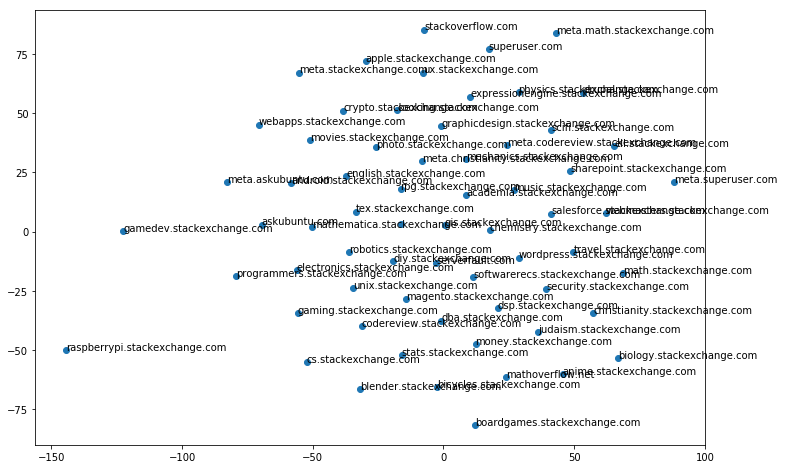

In [30]:
a = list(model.children())
g = a[3].weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000, method='exact')
tsne_results = tsne.fit_transform(g)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1])

for i, txt in enumerate(host_dict.values()):
    ax.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.550050
[t-SNE] KL divergence after 750 iterations: 0.131014


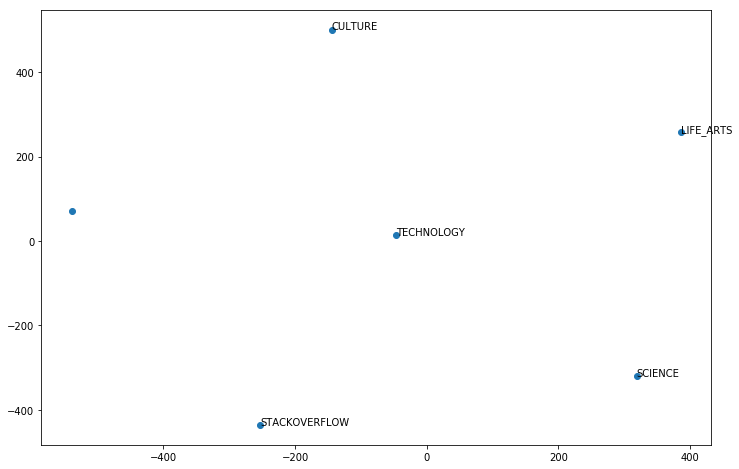

In [31]:
g = a[2].weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000, method='exact')
tsne_results = tsne.fit_transform(g)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1])

for i, txt in enumerate(category_dict.values()):
    ax.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))